In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import chardet
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
train_path = '/data/ephemeral/home/train_final_ver1.csv' 
test_path  = '/data/ephemeral/home/test_final_ver1.csv'

dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.


Train data shape :  (1118822, 18) Test data shape :  (9272, 17)


,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체동수,k-전체세대수,k-연면적,건축면적,x,y,target,아파트명,계약년월,도로명
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,8.0,270.0,22637.0,4858.0,127.05721,37.476763,124000,개포6차우성,201712,언주로 3


,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체동수,k-전체세대수,k-연면적,건축면적,x,y,아파트명,계약년월,도로명
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,26,5,1987,8.0,270.0,22637.0,4858.0,127.05721,37.476763,개포6차우성,202307,언주로 3


In [3]:
print(dt.isnull().sum())
print(dt_test.isnull().sum())

Unnamed: 0         0
복도유형               0
난방방식               0
시군구                0
전용면적               0
계약일                0
층                  0
건축년도               0
k-전체동수        870630
k-전체세대수       869563
k-연면적         869563
건축면적          869714
x                  0
y                  0
target             0
아파트명            2126
계약년월               0
도로명                0
dtype: int64
Unnamed: 0       0
복도유형             0
난방방식             0
시군구              0
전용면적             0
계약일              0
층                0
건축년도             0
k-전체동수        6577
k-전체세대수       6562
k-연면적         6562
건축면적          6565
x                0
y                0
아파트명            10
계약년월             0
도로명              0
dtype: int64


In [4]:
print(dt.info())
print(dt_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1118822 non-null  int64  
 1   복도유형        1118822 non-null  object 
 2   난방방식        1118822 non-null  object 
 3   시군구         1118822 non-null  object 
 4   전용면적        1118822 non-null  float64
 5   계약일         1118822 non-null  int64  
 6   층           1118822 non-null  int64  
 7   건축년도        1118822 non-null  int64  
 8   k-전체동수      248192 non-null   float64
 9   k-전체세대수     249259 non-null   float64
 10  k-연면적       249259 non-null   float64
 11  건축면적        249108 non-null   float64
 12  x           1118822 non-null  float64
 13  y           1118822 non-null  float64
 14  target      1118822 non-null  int64  
 15  아파트명        1116696 non-null  object 
 16  계약년월        1118822 non-null  int64  
 17  도로명         1118822 non-null  object 
dtypes: float64(7), int64(6

In [5]:
# 일단 k-전체동수,k-연면적 ,건축면적, 아파트명 삭제하고 주차대수 + 세대당 주차대수 추가해보자 


# 'k-전체동수', 'k-연면적', '건축면적', '아파트명' 컬럼 삭제
columns_to_drop = ['k-전체동수','k-연면적', '건축면적', '아파트명']
dt.drop(columns=columns_to_drop, inplace=True)
dt_test.drop(columns=columns_to_drop, inplace=True)

# 컬럼 삭제 후 DataFrame 확인
print(dt.info())
print(dt_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1118822 non-null  int64  
 1   복도유형        1118822 non-null  object 
 2   난방방식        1118822 non-null  object 
 3   시군구         1118822 non-null  object 
 4   전용면적        1118822 non-null  float64
 5   계약일         1118822 non-null  int64  
 6   층           1118822 non-null  int64  
 7   건축년도        1118822 non-null  int64  
 8   k-전체세대수     249259 non-null   float64
 9   x           1118822 non-null  float64
 10  y           1118822 non-null  float64
 11  target      1118822 non-null  int64  
 12  계약년월        1118822 non-null  int64  
 13  도로명         1118822 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 119.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column      Non-Nu

In [6]:
# 전용면적 이상치 처리 

print("전용면적 이상치 처리 전 train_data :",dt.shape)
print("전용면적 이상치 처리 전 test_data :",dt_test.shape)


전용면적 이상치 처리 전 train_data : (1118822, 14)
전용면적 이상치 처리 전 test_data : (9272, 13)


## 주차장 관련 피처 추가해보자

In [7]:
pk_train = pd.read_csv('/data/ephemeral/home/train.csv')
pk_test = pd.read_csv('/data/ephemeral/home/test.csv')

pk_train = pk_train['주차대수']
pk_test = pk_test['주차대수']

print(pk_train.info())
print('==================================')
print(pk_test.info())


<class 'pandas.core.series.Series'>
RangeIndex: 1118822 entries, 0 to 1118821
Series name: 주차대수
Non-Null Count   Dtype  
--------------   -----  
249108 non-null  float64
dtypes: float64(1)
memory usage: 8.5 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 9272 entries, 0 to 9271
Series name: 주차대수
Non-Null Count  Dtype  
--------------  -----  
2709 non-null   float64
dtypes: float64(1)
memory usage: 72.6 KB
None


In [8]:
print(pk_train.head(10)) 
print(pk_test.head(10))

0    262.0
1    262.0
2    262.0
3    262.0
4    262.0
5    262.0
6    262.0
7    262.0
8    262.0
9    262.0
Name: 주차대수, dtype: float64
0     262.0
1     305.0
2     419.0
3     419.0
4     419.0
5     652.0
6    1100.0
7    1100.0
8    1100.0
9    3153.0
Name: 주차대수, dtype: float64


In [9]:
# 그냥 인덱스 기준으로 합쳐 

dt['주차대수'] = pk_train
dt_test['주차대수']= pk_test

display(dt)
display(dt_test)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,y,target,계약년월,도로명,주차대수
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.057210,37.476763,124000,201712,언주로 3,262.0
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.057210,37.476763,123500,201712,언주로 3,262.0
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.057210,37.476763,91500,201712,언주로 3,262.0
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.057210,37.476763,130000,201801,언주로 3,262.0
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.057210,37.476763,117000,201801,언주로 3,262.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,1118817,혼합식,개별난방,서울특별시 은평구 구산동,59.94,12,11,1998,366.0,126.905638,37.612962,20000,200707,서오릉로21길 36,366.0
1118818,1118818,혼합식,개별난방,서울특별시 은평구 구산동,59.94,25,10,1998,366.0,126.905638,37.612962,20000,200708,서오릉로21길 36,366.0
1118819,1118819,혼합식,개별난방,서울특별시 은평구 구산동,84.83,31,20,1998,366.0,126.905638,37.612962,28000,200708,서오릉로21길 36,366.0
1118820,1118820,혼합식,개별난방,서울특별시 은평구 구산동,84.83,15,8,1998,366.0,126.905638,37.612962,29000,200709,서오릉로21길 36,366.0


,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,y,계약년월,도로명,주차대수
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.9700,26,5,1987,270.0,127.057210,37.476763,202307,언주로 3,262.0
1,1,계단식,지역난방,서울특별시 강남구 개포동,108.2017,15,10,2021,232.0,127.056394,37.484892,202308,개포로 311,305.0
2,2,혼합식,지역난방,서울특별시 강남구 개포동,161.0000,28,15,1984,405.0,127.055990,37.483894,202307,개포로 307,419.0
3,3,혼합식,지역난방,서울특별시 강남구 개포동,133.4600,10,14,1984,405.0,127.055990,37.483894,202308,개포로 307,419.0
4,4,혼합식,지역난방,서울특별시 강남구 개포동,104.4300,18,6,1984,405.0,127.055990,37.483894,202308,개포로 307,419.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.6500,19,13,2014,1402.0,127.106720,37.618870,202307,신내역로1길 85,1568.0
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.6200,25,12,2014,1402.0,127.106720,37.618870,202307,신내역로1길 85,1568.0
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.6500,27,12,2014,1402.0,127.106720,37.618870,202308,신내역로1길 85,1568.0
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.9400,2,18,2014,1402.0,127.106720,37.618870,202309,신내역로1길 85,1568.0


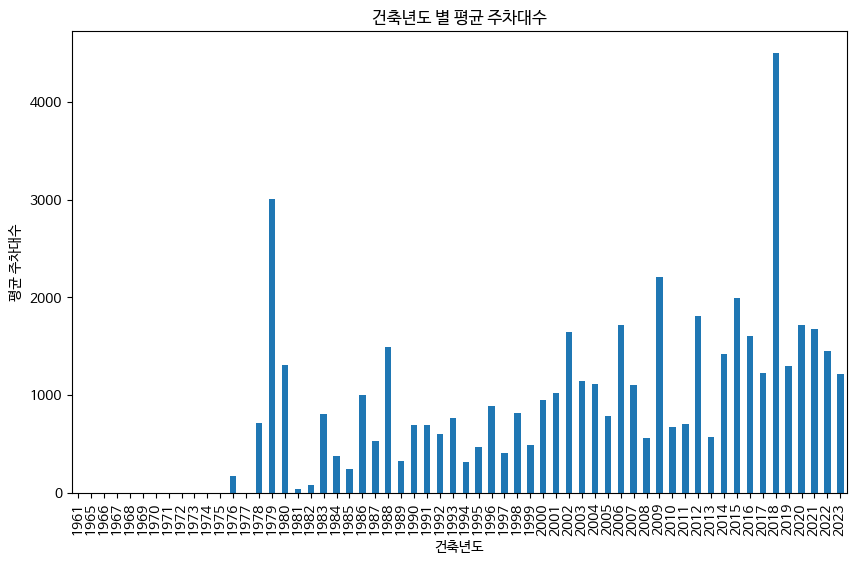

In [10]:
# '건축년도' 별로 '주차대수'의 평균을 계산
parking_by_year = dt.groupby('건축년도')['주차대수'].mean()

plt.figure(figsize=(10, 6))
parking_by_year.plot(kind='bar')
plt.title('건축년도 별 평균 주차대수')
plt.xlabel('건축년도')
plt.ylabel('평균 주차대수')
plt.show()
# 그냥 이래버리면 의미가 없음. 세대 수를 고려한 건축년도 별 평균 주차대수를 구해야하는데 세대 수가 아직 결측치가 안채워져있으니... 
# 그냥 선형보간으로 채우고 , 세대수도 선형보간으로 채우고, 년도별 세대 수 당 평균 주차대수 컬럼 3개 추가해서 돌려보고 rmse:100362.0131보다 얼마나 작아지는지 변화 추이 확인 ㄱㄱ 	

### 

In [11]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.
print("전용면적 이상치 처리 전 concat_data :",concat.shape)

전용면적 이상치 처리 전 concat_data : (1128094, 16)


In [12]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['Unnamed: 0', '전용면적', '계약일', '층', '건축년도', 'k-전체세대수', 'x', 'y', 'target', '계약년월', '주차대수', 'is_test']
범주형 변수: ['복도유형', '난방방식', '시군구', '도로명']


In [13]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [14]:
concat.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

Unnamed: 0    0
복도유형          0
난방방식          0
시군구           0
전용면적          0
계약일           0
층             0
건축년도          0
k-전체세대수       0
x             0
y             0
target        0
계약년월          0
도로명           0
주차대수          0
is_test       0
dtype: int64

In [15]:
display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,y,target,계약년월,도로명,주차대수,is_test
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,37.476763,124000.0,201712,언주로 3,262.0,0
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,37.476763,123500.0,201712,언주로 3,262.0,0
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,37.476763,91500.0,201712,언주로 3,262.0,0
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,37.476763,130000.0,201801,언주로 3,262.0,0
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,37.476763,117000.0,201801,언주로 3,262.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,37.618870,13250.0,202308,신내역로1길 85,1568.0,1
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,37.618870,13250.0,202309,신내역로1길 85,1568.0,1


In [16]:
# 이제 선형보간 처리했으니 관련 컬럼 3개 추가해보자 

# 각 건물의 세대수당 주차대수 계산 -> 개별 건물의 세대수당 주차 공간 비율을 나타냄
concat['세대수당_주차대수'] = concat['주차대수'] / concat['k-전체세대수']

# 년도별 세대수당 주차대수 계산 -> 각 연도별 전체 평균 세대수당 주차 공간 비율을 나타냄
yearly_totals = concat.groupby('건축년도').agg({'주차대수': 'sum', 'k-전체세대수': 'sum'})
yearly_averages = yearly_totals['주차대수'] / yearly_totals['k-전체세대수']
concat['년도별_세대수당_평균_주차대수'] = concat['건축년도'].map(yearly_averages)

# 첫 번째 방법은 개별 건물의 특성을 반영하는 반면, 두 번째 방법은 연도별 전체적인 추세를 나타냄.
# 두 번째 방법은 시간에 따른 변화를 더 잘 파악하는 데 유용, 예를 들어, 시간이 지남에 따라 주차 공간 비율이 어떻게 변화하는지 분석 가능.

display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,y,target,계약년월,도로명,주차대수,is_test,세대수당_주차대수,년도별_세대수당_평균_주차대수
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,37.476763,124000.0,201712,언주로 3,262.0,0,0.970370,0.851326
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,37.476763,123500.0,201712,언주로 3,262.0,0,0.970370,0.851326
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,37.476763,91500.0,201712,언주로 3,262.0,0,0.970370,0.851326
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,37.476763,130000.0,201801,언주로 3,262.0,0,0.970370,0.851326
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,37.476763,117000.0,201801,언주로 3,262.0,0,0.970370,0.851326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1,1.118402,1.137960
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1,1.118402,1.137960
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,37.618870,13250.0,202308,신내역로1길 85,1568.0,1,1.118402,1.137960
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,37.618870,13250.0,202309,신내역로1길 85,1568.0,1,1.118402,1.137960


In [17]:
concat.isnull().sum()  # ㅇㅋ 새로 추가한 컬럼도 결측치 없음 확인 

Unnamed: 0          0
복도유형                0
난방방식                0
시군구                 0
전용면적                0
계약일                 0
층                   0
건축년도                0
k-전체세대수             0
x                   0
y                   0
target              0
계약년월                0
도로명                 0
주차대수                0
is_test             0
세대수당_주차대수           0
년도별_세대수당_평균_주차대수    0
dtype: int64

## 파생변수 추가: 건축년도를 기반으로한 건물의 연령 : 현재 연도 - 건축연도  
- 의미가 있을까? 혹시모르니...(건축 기술 및 재료의 변화,건물의 상태와 유지보수,디자인 및 구조의 현대성,건축 규제의 변화)
- 따라서, "건축년도" 자체보다는 현재 연도와의 차이를 통해 계산된 "건물 연령"이 주택 가격에 미치는 영향을 보다 직접적으로 반영할 수 있으며, 이는 예측 모델의 정확도를 높일 수 있음. 

In [18]:
concat['건물나이'] = 2023 - concat['건축년도']
display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,y,target,계약년월,도로명,주차대수,is_test,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,37.476763,124000.0,201712,언주로 3,262.0,0,0.970370,0.851326,36
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,37.476763,123500.0,201712,언주로 3,262.0,0,0.970370,0.851326,36
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,37.476763,91500.0,201712,언주로 3,262.0,0,0.970370,0.851326,36
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,37.476763,130000.0,201801,언주로 3,262.0,0,0.970370,0.851326,36
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,37.476763,117000.0,201801,언주로 3,262.0,0,0.970370,0.851326,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1,1.118402,1.137960,9
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,37.618870,13250.0,202307,신내역로1길 85,1568.0,1,1.118402,1.137960,9
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,37.618870,13250.0,202308,신내역로1길 85,1568.0,1,1.118402,1.137960,9
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,37.618870,13250.0,202309,신내역로1길 85,1568.0,1,1.118402,1.137960,9


## 파생변수 추가: 빌딩간격 -> 단지 내에서 최고 높은 건물과 가장 낮은 건물 높이 차이 계산 
- 이를 위해서 최고층,최저층 컬럼도 추가해야함 (x,y)좌표 기준으로 같으면 같은 단지로 가정하고 생성


In [19]:
# 동일 아파트 단지 내에서 최고층과 최저층 계산
concat['최고층'] = concat.groupby(['x', 'y'])['층'].transform('max')
concat['최저층'] = concat.groupby(['x', 'y'])['층'].transform('min')

# 빌딩 간격 계산
concat['빌딩간격'] = concat['최고층'] - concat['최저층']

display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,계약년월,도로명,주차대수,is_test,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,최저층,빌딩간격
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,...,201712,언주로 3,262.0,0,0.970370,0.851326,36,5,1,4
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,...,201712,언주로 3,262.0,0,0.970370,0.851326,36,5,1,4
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,...,201712,언주로 3,262.0,0,0.970370,0.851326,36,5,1,4
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,...,201801,언주로 3,262.0,0,0.970370,0.851326,36,5,1,4
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,...,201801,언주로 3,262.0,0,0.970370,0.851326,36,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,...,202307,신내역로1길 85,1568.0,1,1.118402,1.137960,9,24,1,23
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,...,202307,신내역로1길 85,1568.0,1,1.118402,1.137960,9,24,1,23
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,...,202308,신내역로1길 85,1568.0,1,1.118402,1.137960,9,24,1,23
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,...,202309,신내역로1길 85,1568.0,1,1.118402,1.137960,9,24,1,23


## 파생변수 추가: 아파트당 타입 비율 계산: 특정 면적 타입의 세대 수를 총 세대 수로 나누어 아파트당 타입 비율을 계산
- (0, 30), (30, 60), (60, 90), (90, 120), (120~) 범위 5개로 나누어 추가 

In [20]:
area_ranges = [(0, 30), (30, 60), (60, 90), (90, 120), (120, float('inf'))] # 5개 추가 범위 별 
for i, (start, end) in enumerate(area_ranges, 1):
    column_name = f'type_ratio_{start}_{end}'
    concat[column_name] = concat['전용면적'].apply(lambda x: start <= x < end).astype(int)
    concat[column_name] = concat.groupby('k-전체세대수')[column_name].transform('sum') / concat['k-전체세대수']
display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,년도별_세대수당_평균_주차대수,건물나이,최고층,최저층,빌딩간격,type_ratio_0_30,type_ratio_30_60,type_ratio_60_90,type_ratio_90_120,type_ratio_120_inf
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,...,0.851326,36,5,1,4,0.0,0.066667,0.322222,0.00000,0.003704
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,...,0.851326,36,5,1,4,0.0,0.066667,0.322222,0.00000,0.003704
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,...,0.851326,36,5,1,4,0.0,0.066667,0.322222,0.00000,0.003704
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,...,0.851326,36,5,1,4,0.0,0.066667,0.322222,0.00000,0.003704
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,...,0.851326,36,5,1,4,0.0,0.066667,0.322222,0.00000,0.003704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,...,1.137960,9,24,1,23,0.0,0.072753,0.391583,0.03923,0.000000
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,...,1.137960,9,24,1,23,0.0,0.072753,0.391583,0.03923,0.000000
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,...,1.137960,9,24,1,23,0.0,0.072753,0.391583,0.03923,0.000000
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,...,1.137960,9,24,1,23,0.0,0.072753,0.391583,0.03923,0.000000


In [21]:
filtered_data = concat[(concat['x'] == 127.05721) & (concat['전용면적'] > 120)]

# 결과 출력
if not filtered_data.empty:
    print("전용면적이 120을 넘는 데이터가 있습니다.")
    print(filtered_data)
else:
    print("전용면적이 120을 넘는 데이터가 없습니다.") # 없는데도 0.003704 이런 식으로 표시되긴 하는 구먼 

전용면적이 120을 넘는 데이터가 없습니다.


## 파생변수 추가: 최근 거래와의 차이 계산: 동일 아파트의 이전 거래 월과 현재 거래 월의 차이를 계산

In [22]:
concat['계약년월']

0       201712
1       201712
2       201712
3       201801
4       201801
         ...  
9267    202307
9268    202307
9269    202308
9270    202309
9271    202309
Name: 계약년월, Length: 1128094, dtype: int64

In [23]:
# 계약년월과 계약일을 결합하여 전체 거래 날짜를 생성
concat['거래날짜'] = pd.to_datetime(concat['계약년월'].astype(str) + concat['계약일'].astype(str), format='%Y%m%d')

# x, y 좌표를 기준으로 동일 아파트의 이전 거래와의 날짜 차이 계산
concat['이전거래날짜'] = concat.groupby(['x', 'y'])['거래날짜'].shift(1)
concat['거래날차이'] = (concat['거래날짜'] - concat['이전거래날짜']).dt.days

display(concat)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,최저층,빌딩간격,type_ratio_0_30,type_ratio_30_60,type_ratio_60_90,type_ratio_90_120,type_ratio_120_inf,거래날짜,이전거래날짜,거래날차이
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,...,1,4,0.0,0.066667,0.322222,0.00000,0.003704,2017-12-08,NaT,NaN
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,...,1,4,0.0,0.066667,0.322222,0.00000,0.003704,2017-12-22,2017-12-08,14.0
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,...,1,4,0.0,0.066667,0.322222,0.00000,0.003704,2017-12-28,2017-12-22,6.0
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,...,1,4,0.0,0.066667,0.322222,0.00000,0.003704,2018-01-03,2017-12-28,6.0
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,...,1,4,0.0,0.066667,0.322222,0.00000,0.003704,2018-01-08,2018-01-03,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,...,1,23,0.0,0.072753,0.391583,0.03923,0.000000,2023-07-19,2014-09-30,3214.0
9268,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,...,1,23,0.0,0.072753,0.391583,0.03923,0.000000,2023-07-25,2023-07-19,6.0
9269,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,...,1,23,0.0,0.072753,0.391583,0.03923,0.000000,2023-08-27,2023-07-25,33.0
9270,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,...,1,23,0.0,0.072753,0.391583,0.03923,0.000000,2023-09-02,2023-08-27,6.0


In [24]:
print(concat['이전거래날짜'].info()) # 이거에 대한 널 값 처리 해야함 -> 데이터 기준 첫 째 거래는 이전 거래 날짜가 없음. 
print(concat['거래날차이'].info()) # 이거에 대한 널 값 처리 해야함 -> 데이터 기준 첫 째 거래는 거래 날 차이가 없음. 


<class 'pandas.core.series.Series'>
Int64Index: 1128094 entries, 0 to 9271
Series name: 이전거래날짜
Non-Null Count    Dtype         
--------------    -----         
1122207 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.2 MB
None
<class 'pandas.core.series.Series'>
Int64Index: 1128094 entries, 0 to 9271
Series name: 거래날차이
Non-Null Count    Dtype  
--------------    -----  
1122207 non-null  float64
dtypes: float64(1)
memory usage: 17.2 MB
None


In [25]:
# '이전거래날짜'가 null인 경우 '거래날짜'로 대체하고, '거래차이'가 null인 경우 0으로 대체
concat['이전거래날짜'] = concat['이전거래날짜'].fillna(concat['거래날짜'])
concat['거래날차이'] = concat['거래날차이'].fillna(0)

print(concat[['이전거래날짜', '거래날차이']])

         이전거래날짜   거래날차이
0    2017-12-08     0.0
1    2017-12-08    14.0
2    2017-12-22     6.0
3    2017-12-28     6.0
4    2018-01-03     5.0
...         ...     ...
9267 2014-09-30  3214.0
9268 2023-07-19     6.0
9269 2023-07-25    33.0
9270 2023-08-27     6.0
9271 2023-09-02     2.0

[1128094 rows x 2 columns]


In [26]:
concat.drop(['거래날짜', '이전거래날짜'], axis=1, inplace=True)

## 파생변수 추가: 구별 급여총계 데이터 이용 (2016~2021) 2007~2015, 2021~2023은 linear interpolate로 처리 

https://kosis.kr/statHtml/statHtml.do?tblId=DT_133001N_4215&orgId=133&language=kor&conn_path=&vw_cd=&list_id 데이터 링크 

In [27]:
money = pd.read_csv('/data/ephemeral/home/money.csv')
display(money)

,행정구역(시군구)별(1),행정구역(시군구)별(2),2016,2016.1,2016.2,2016.3,2016.4,2016.5,2016.6,2016.7,...,2020.6,2020.7,2021,2021.1,2021.2,2021.3,2021.4,2021.5,2021.6,2021.7
0,행정구역(시군구)별(1),행정구역(시군구)별(2),급여총계,급여총계,과세대상근로소득(총급여),과세대상근로소득(총급여),과세표준,과세표준,결정세액,결정세액,...,결정세액,결정세액,급여총계,급여총계,과세대상근로소득(총급여),과세대상근로소득(총급여),과세표준,과세표준,결정세액,결정세액
1,행정구역(시군구)별(1),행정구역(시군구)별(2),인원 (명),금액 (백만원),인원 (명),금액 (백만원),인원 (명),금액 (백만원),인원 (명),금액 (백만원),...,인원 (명),금액 (백만원),인원 (명),금액 (백만원),인원 (명),금액 (백만원),인원 (명),금액 (백만원),인원 (명),금액 (백만원)
2,전국,소계,17740098,600099695,17668285,595990661,15419516,320805519,9998156,30853854,...,12240163,44164060,19959148,807198885,19907727,803208612,17857818,455957519,12919174,52698621
3,서울,소계,3629625,138096837,3621150,137226200,3159795,79865568,2099483,10035736,...,2434090,14415848,3952583,184858796,3944244,184066506,3537573,113851288,2565528,17333494
4,서울,강남구,206668,13057288,206346,12989836,185324,9108357,139670,1761616,...,150113,2434790,215632,17477665,215441,17417230,197339,12781199,156295,2932330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,경남,합천군,9315,262452,9204,260814,8048,127450,4919,7764,...,5907,10602,9838,317420,9816,316507,8846,162244,6086,11417
245,제주,소계,197972,5705113,197102,5674147,169719,2826393,101628,226606,...,134640,333303,232571,7985643,232345,7951570,207655,4141826,142908,375971
246,제주,제주시,150621,4389021,150155,4366483,129793,2174513,77749,171441,...,102047,245983,175810,6064037,175652,6039377,157106,3132000,107941,277434
247,제주,서귀포시,47351,1316092,46947,1307664,39926,651880,23879,55165,...,32593,87319,56761,1921607,56693,1912193,50549,1009826,34967,98537


In [28]:
money.loc[0, :] = money.loc[0, :].where(money.loc[0, :] == '급여총계').fillna('')

# 인덱스 1에서 '인원 (명)'과 '금액 (백만원)' 열만 남기기
money.loc[1, :] = money.loc[1, :].where((money.loc[1, :] == '인원 (명)') | (money.loc[1, :] == '금액 (백만원)')).fillna('')

columns_to_keep = ['행정구역(시군구)별(1)','행정구역(시군구)별(2)','2016', '2016.1', '2017', '2017.1', '2018', '2018.1', '2019', '2019.1', '2020', '2020.1', '2021', '2021.1']

# 선택된 열들만을 포함하는 새로운 데이터프레임 생성
filtered_data = money[columns_to_keep]
seoul_data = filtered_data[filtered_data['행정구역(시군구)별(1)'] == '서울']
# 결과 확인
display(seoul_data)

,행정구역(시군구)별(1),행정구역(시군구)별(2),2016,2016.1,2017,2017.1,2018,2018.1,2019,2019.1,2020,2020.1,2021,2021.1
3,서울,소계,3629625,138096837,3645417,146379773,3743474,155269460,3845841,164800618,3871889,170371416,3952583,184858796
4,서울,강남구,206668,13057288,201206,14142558,206821,14403588,209653,14926829,210941,15754700,215632,17477665
5,서울,강동구,161837,5614760,160371,5824940,165248,6291291,183833,7447177,189102,7865918,192080,8488374
6,서울,강북구,102249,2647871,102117,2764297,103391,2913526,105025,3075447,105321,3109922,105489,3274497
7,서울,강서구,233511,7710165,236070,8221014,242516,8809099,245495,9178851,247909,9287969,252396,9964209
8,서울,관악구,202189,5779387,205325,6098873,212016,6521099,217483,6865539,217065,6961669,224352,7550177
9,서울,광진구,137927,4657189,139502,4949835,142631,5250413,145629,5495292,146304,5629534,150149,6121949
10,서울,구로구,163520,5055671,162000,5264673,166803,5614023,171843,5972692,171669,6079037,174004,6504808
11,서울,금천구,91194,2411167,91260,2531695,95166,2766103,98934,2973640,100692,3103521,104225,3388533
12,서울,노원구,189827,6503565,188364,6697695,189212,6942109,191248,7206570,191648,7363982,194250,7784253


In [29]:
years = [2016, 2017, 2018, 2019, 2020, 2021]

for year in years:
    year_col = str(year)     
    year_point_col = str(year) + '.1'  

    new_col = str(year) + '_ratio'
    
    seoul_data[new_col] = pd.to_numeric(seoul_data[year_point_col], errors='coerce') / pd.to_numeric(seoul_data[year_col], errors='coerce')


display(seoul_data)

,행정구역(시군구)별(1),행정구역(시군구)별(2),2016,2016.1,2017,2017.1,2018,2018.1,2019,2019.1,2020,2020.1,2021,2021.1,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
3,서울,소계,3629625,138096837,3645417,146379773,3743474,155269460,3845841,164800618,3871889,170371416,3952583,184858796,38.047136,40.154466,41.477371,42.851646,44.002144,46.769112
4,서울,강남구,206668,13057288,201206,14142558,206821,14403588,209653,14926829,210941,15754700,215632,17477665,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
5,서울,강동구,161837,5614760,160371,5824940,165248,6291291,183833,7447177,189102,7865918,192080,8488374,34.693920,36.321654,38.071813,40.510556,41.596165,44.191868
6,서울,강북구,102249,2647871,102117,2764297,103391,2913526,105025,3075447,105321,3109922,105489,3274497,25.896302,27.069900,28.179687,29.282999,29.528033,31.041123
7,서울,강서구,233511,7710165,236070,8221014,242516,8809099,245495,9178851,247909,9287969,252396,9964209,33.018423,34.824476,36.323785,37.389157,37.465235,39.478474
8,서울,관악구,202189,5779387,205325,6098873,212016,6521099,217483,6865539,217065,6961669,224352,7550177,28.584082,29.703509,30.757580,31.568164,32.071817,33.653264
9,서울,광진구,137927,4657189,139502,4949835,142631,5250413,145629,5495292,146304,5629534,150149,6121949,33.765608,35.482179,36.811163,37.734874,38.478333,40.772493
10,서울,구로구,163520,5055671,162000,5264673,166803,5614023,171843,5972692,171669,6079037,174004,6504808,30.917753,32.497981,33.656607,34.756679,35.411385,37.383095
11,서울,금천구,91194,2411167,91260,2531695,95166,2766103,98934,2973640,100692,3103521,104225,3388533,26.439974,27.741563,29.066085,30.056806,30.821922,32.511710
12,서울,노원구,189827,6503565,188364,6697695,189212,6942109,191248,7206570,191648,7363982,194250,7784253,34.260485,35.557192,36.689581,37.681806,38.424518,40.073375


In [30]:
# 삭제할 열 목록
columns_to_drop = ['행정구역(시군구)별(1)','2016', '2016.1', '2017', '2017.1', '2018', '2018.1', '2019', '2019.1', '2020', '2020.1', '2021','2021.1']

# 열 삭제
seoul_data = seoul_data.drop(columns=columns_to_drop)

# 결과 확인
display(seoul_data)

,행정구역(시군구)별(2),2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
3,소계,38.047136,40.154466,41.477371,42.851646,44.002144,46.769112
4,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
5,강동구,34.693920,36.321654,38.071813,40.510556,41.596165,44.191868
6,강북구,25.896302,27.069900,28.179687,29.282999,29.528033,31.041123
7,강서구,33.018423,34.824476,36.323785,37.389157,37.465235,39.478474
8,관악구,28.584082,29.703509,30.757580,31.568164,32.071817,33.653264
9,광진구,33.765608,35.482179,36.811163,37.734874,38.478333,40.772493
10,구로구,30.917753,32.497981,33.656607,34.756679,35.411385,37.383095
11,금천구,26.439974,27.741563,29.066085,30.056806,30.821922,32.511710
12,노원구,34.260485,35.557192,36.689581,37.681806,38.424518,40.073375


In [31]:
# 첫 번째 데이터에 있는 "시군구" 정보에서 "구" 이름만 추출하여 새로운 열 추가
concat['구'] = concat['시군구'].str.split().str[1]

# 두 번째 데이터프레임과 합치기 위해 열 이름 통일
seoul_data.rename(columns={'행정구역(시군구)별(2)': '구'}, inplace=True)

# 두 개의 데이터프레임을 "구" 열을 기준으로 merge
merged_data = pd.merge(concat, seoul_data, on='구')

# 선택할 컬럼 목록
selected_columns = ['구', '2016_ratio', '2017_ratio', '2018_ratio', '2019_ratio', '2020_ratio', '2021_ratio']

# 선택한 컬럼으로 새로운 데이터프레임 생성
final_data = merged_data[selected_columns]

# 결과 확인
display(final_data)


,구,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
0,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
1,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
2,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
3,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
4,강남구,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
...,...,...,...,...,...,...,...
1128089,중랑구,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128090,중랑구,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128091,중랑구,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128092,중랑구,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432


In [32]:
merged_data=merged_data.drop(columns='구') # 일단 2007~2015_ratio, 2022~2023_ratio는 보류 
merged_data 
concat = merged_data
concat

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,type_ratio_60_90,type_ratio_90_120,type_ratio_120_inf,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
0,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,3,1987,270.0,127.05721,...,0.322222,0.00000,0.003704,0.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
1,1,계단식,개별난방,서울특별시 강남구 개포동,79.97,22,4,1987,270.0,127.05721,...,0.322222,0.00000,0.003704,14.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
2,2,계단식,개별난방,서울특별시 강남구 개포동,54.98,28,5,1987,270.0,127.05721,...,0.322222,0.00000,0.003704,6.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
3,3,계단식,개별난방,서울특별시 강남구 개포동,79.97,3,4,1987,270.0,127.05721,...,0.322222,0.00000,0.003704,6.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
4,4,계단식,개별난방,서울특별시 강남구 개포동,79.97,8,2,1987,270.0,127.05721,...,0.322222,0.00000,0.003704,5.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,9267,혼합식,개별난방,서울특별시 중랑구 신내동,84.65,19,13,2014,1402.0,127.10672,...,0.391583,0.03923,0.000000,3214.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128090,9268,혼합식,개별난방,서울특별시 중랑구 신내동,84.62,25,12,2014,1402.0,127.10672,...,0.391583,0.03923,0.000000,6.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128091,9269,혼합식,개별난방,서울특별시 중랑구 신내동,101.65,27,12,2014,1402.0,127.10672,...,0.391583,0.03923,0.000000,33.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432
1128092,9270,혼합식,개별난방,서울특별시 중랑구 신내동,84.94,2,18,2014,1402.0,127.10672,...,0.391583,0.03923,0.000000,6.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432


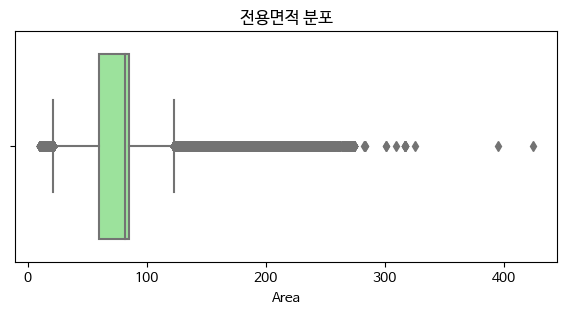

In [33]:
# 이상치 처리 
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [34]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [35]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat = remove_outliers_iqr(concat, '전용면적')
print("전용면적 이상치 처리 후 concat_data :",concat.shape) # 89248개 삭제 됨.

전용면적 이상치 처리 후 concat_data : (1038846, 34)


In [36]:
concat['is_test'].value_counts()  # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## model training

In [37]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 33) (9272, 33)


In [38]:
dt_test.head(1)

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,type_ratio_60_90,type_ratio_90_120,type_ratio_120_inf,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
69083,0,계단식,개별난방,서울특별시 강남구 개포동,79.97,26,5,1987,270.0,127.05721,...,0.322222,0.0,0.003704,5983.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206


In [39]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [40]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['Unnamed: 0', '전용면적', '계약일', '층', '건축년도', 'k-전체세대수', 'x', 'y', 'target', '계약년월', '주차대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수', '건물나이', '최고층', '최저층', '빌딩간격', 'type_ratio_0_30', 'type_ratio_30_60', 'type_ratio_60_90', 'type_ratio_90_120', 'type_ratio_120_inf', '거래날차이', '2016_ratio', '2017_ratio', '2018_ratio', '2019_ratio', '2020_ratio', '2021_ratio']
범주형 변수: ['복도유형', '난방방식', '시군구', '도로명']


In [41]:
# 'your_column_name'은 실제 데이터의 열 이름으로 대체해야 합니다.
problematic_data = dt_test[dt_test['y'] == '2023-07-26']
print(problematic_data)


Empty DataFrame
Columns: [Unnamed: 0, 복도유형, 난방방식, 시군구, 전용면적, 계약일, 층, 건축년도, k-전체세대수, x, y, target, 계약년월, 도로명, 주차대수, 세대수당_주차대수, 년도별_세대수당_평균_주차대수, 건물나이, 최고층, 최저층, 빌딩간격, type_ratio_0_30, type_ratio_30_60, type_ratio_60_90, type_ratio_90_120, type_ratio_120_inf, 거래날차이, 2016_ratio, 2017_ratio, 2018_ratio, 2019_ratio, 2020_ratio, 2021_ratio]
Index: []

[0 rows x 33 columns]


In [42]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


In [43]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,type_ratio_60_90,type_ratio_90_120,type_ratio_120_inf,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio
0,0,0,0,0,79.97,8,3,1987,270.0,127.05721,...,0.322222,0.0,0.003704,0.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206


In [44]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

# RMSE test: 5851.882141463051 -> baseline        # public rmse : 100063.7807
# RMSE test: 5542.436556927391 -> 주차대수, 세대수당_주차대수, 년도별_세대수당_평균_주차대수, k- 전체세대수 : 선형보간으로 결측치 채우고 ['k-전체동수','k-연면적', '건축면적', '아파트명']은 걍 drop   # public rmse : 100353.2661
# RMSE test: 5240.558573703583 -> 건물나이, 빌딩간격, 아파트당 타입비율 계산, 최근 거래와의 차이 날 수 , 연도별 급여총계(2016~2021) 피처 추가  : 총 33개  # public rmse : 99510.1904

###################################################
# RMSE test: 7033.167517642885 -> 준형님 베이스라인  


RMSE test: 5240.558573703583


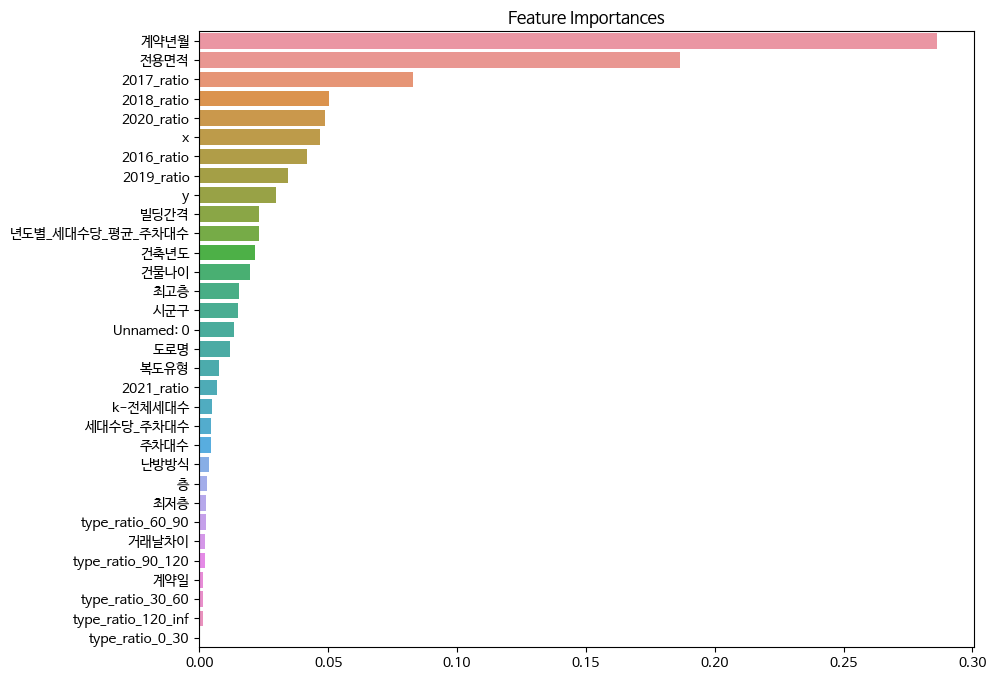

In [45]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [46]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [47]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [48]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [49]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting
X_val_sort.head()

,Unnamed: 0,복도유형,난방방식,시군구,전용면적,계약일,층,건축년도,k-전체세대수,x,...,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,target,pred,error
15562,223914,0,2,4,115.93,17,21,2021,398.932166,127.050674,...,18.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,501750.0,347000.0,2.394756e+10
725508,944622,0,2,128,107.47,10,3,1973,1129.000000,127.002570,...,27.0,63.203370,68.563794,69.013977,71.177583,74.406403,80.510746,48000.0,193600.0,2.119936e+10
847364,218285,0,2,182,113.18,7,22,2021,1626.420922,127.105800,...,4916.0,44.854793,46.755214,48.933412,50.591584,52.085112,55.703664,148000.0,284000.0,1.849600e+10
15918,224524,0,2,11,84.72,25,23,2021,2104.000000,127.074159,...,211.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,150000.0,281400.0,1.726596e+10
32200,446911,0,2,10,114.91,14,1,2015,560.804896,127.047300,...,85.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,90000.0,219000.0,1.664100e+10


## inference

In [50]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [51]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 9.86 ms, sys: 12.1 ms, total: 22 ms
Wall time: 16.7 ms


In [52]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([188880., 244000., 202800., ...,  84100.,  81100.,  75360.])

In [53]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)